# Deep Convolutional Generative Adversarial Network (DCGAN) Tutorial



Adapted from Arthur Juliani, see his post here [Medium post](https://medium.com/p/54deab2fce39) on his implementation of DCGAN.

In [0]:
#Import the libraries we will need.
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import os
import scipy.misc
import scipy

We will be using the MNIST dataset. input_data is a library that downloads the dataset and uzips it automatically.

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### Helper Functions

In [0]:
#This function performns a leaky relu activation, which is needed for the discriminator network.
def lrelu(x, leak=0.2, name="lrelu"):
     with tf.variable_scope(name):
         f1 = 0.5 * (1 + leak)
         f2 = 0.5 * (1 - leak)
         return f1 * x + f2 * abs(x)
    
#The below functions are taken from carpdem20's implementation https://github.com/carpedm20/DCGAN-tensorflow
#They allow for saving sample images from the generator to follow progress
#def save_images(images, size, image_path):
#    return imsave(inverse_transform(images), size, image_path)

#def imsave(images, size, path):
#    return scipy.misc.imsave(path, merge(images, size))

def inverse_transform(images):
    return (images+1.)/2.

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1]))

    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w] = image

    return img

## Defining the Adversarial Networks

### Generator Network

The generator takes a vector of random numbers and transforms it into a 32x32 image. Each layer in the network involves a strided  transpose convolution, batch normalization, and rectified nonlinearity. Tensorflow's slim library allows us to easily define each of these layers.

In [0]:
def generator(z):
    
    zP = slim.fully_connected(z,4*4*256,normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_project',weights_initializer=initializer)
    zCon = tf.reshape(zP,[-1,4,4,256])
    
    gen1 = slim.convolution2d_transpose(\
        zCon,num_outputs=64,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv1', weights_initializer=initializer)
    
    gen2 = slim.convolution2d_transpose(\
        gen1,num_outputs=32,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv2', weights_initializer=initializer)
    
    gen3 = slim.convolution2d_transpose(\
        gen2,num_outputs=16,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv3', weights_initializer=initializer)
    
    g_out = slim.convolution2d_transpose(\
        gen3,num_outputs=1,kernel_size=[32,32],padding="SAME",\
        biases_initializer=None,activation_fn=tf.nn.tanh,\
        scope='g_out', weights_initializer=initializer)
    
    return g_out

### Discriminator Network
The discriminator network takes as input a 32x32 image and transforms it into a single valued probability of being generated from real-world data. Again we use tf.slim to define the convolutional layers, batch normalization, and weight initialization.

In [0]:
def discriminator(bottom, reuse=False):
    
    dis1 = slim.convolution2d(bottom,16,[4,4],stride=[2,2],padding="SAME",\
        biases_initializer=None,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv1',weights_initializer=initializer)
    
    dis2 = slim.convolution2d(dis1,32,[4,4],stride=[2,2],padding="SAME",\
        normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv2', weights_initializer=initializer)
    
    dis3 = slim.convolution2d(dis2,64,[4,4],stride=[2,2],padding="SAME",\
        normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv3',weights_initializer=initializer)
    
    d_out = slim.fully_connected(slim.flatten(dis3),1,activation_fn=tf.nn.sigmoid,\
        reuse=reuse,scope='d_out', weights_initializer=initializer)
    
    return d_out

### Connecting them together

In [0]:
tf.reset_default_graph()

z_size = 100 #Size of z vector used for generator.

#This initializaer is used to initialize all the weights of the network.
initializer = tf.truncated_normal_initializer(stddev=0.02)

#These two placeholders are used for input into the generator and discriminator, respectively.
z_in = tf.placeholder(shape=[None,z_size],dtype=tf.float32) #Random vector
real_in = tf.placeholder(shape=[None,32,32,1],dtype=tf.float32) #Real images

Gz = generator(z_in) #Generates images from random z vectors
Dx = discriminator(real_in) #Produces probabilities for real images
Dg = discriminator(Gz,reuse=True) #Produces probabilities for generator images

#These functions together define the optimization objective of the GAN.
d_loss = -tf.reduce_mean(tf.log(Dx) + tf.log(1.-Dg)) #This optimizes the discriminator.
g_loss = -tf.reduce_mean(tf.log(Dg)) #This optimizes the generator.

tvars = tf.trainable_variables()

#The below code is responsible for applying gradient descent to update the GAN.
trainerD = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
trainerG = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
d_grads = trainerD.compute_gradients(d_loss,tvars[9:]) #Only update the weights for the discriminator network.
g_grads = trainerG.compute_gradients(g_loss,tvars[0:9]) #Only update the weights for the generator network.

update_D = trainerD.apply_gradients(d_grads)
update_G = trainerG.apply_gradients(g_grads)

## Training the network
Now that we have fully defined our network, it is time to train it!

Gen Loss: 0.331932 Disc Loss: 1.3978977


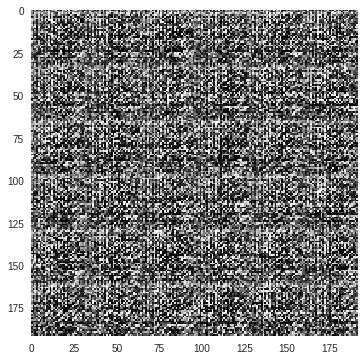

Gen Loss: 0.8134961 Disc Loss: 1.5423548


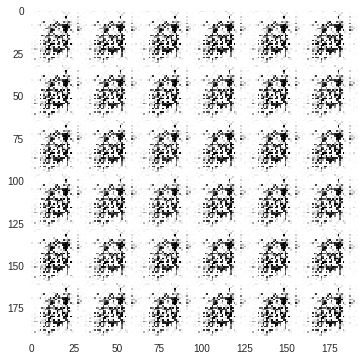

Gen Loss: 1.0717318 Disc Loss: 1.2096362


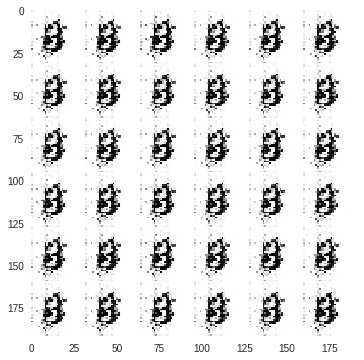

Gen Loss: 0.71102554 Disc Loss: 1.3883327


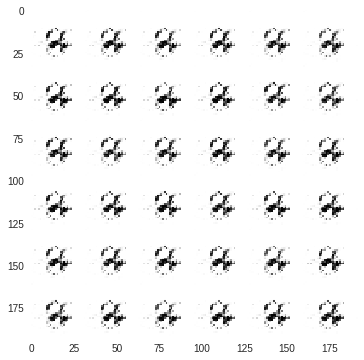

Gen Loss: 1.1650313 Disc Loss: 1.0750442


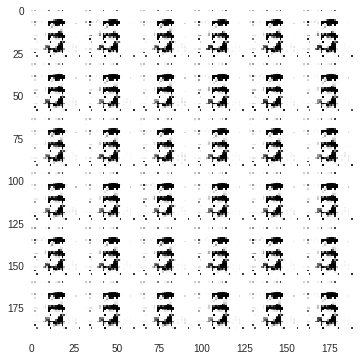

Gen Loss: 0.9460145 Disc Loss: 1.2414255


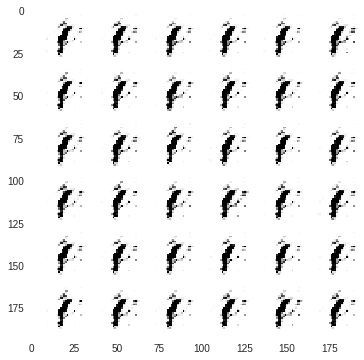

Gen Loss: 1.4278075 Disc Loss: 0.85151935


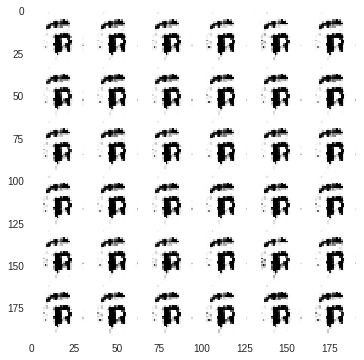

Gen Loss: 1.2936676 Disc Loss: 0.9872172


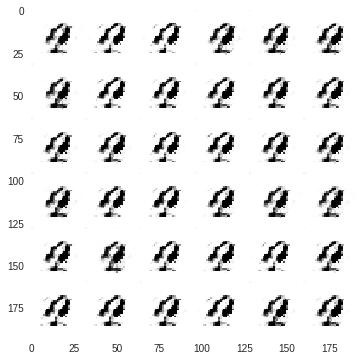

Gen Loss: 1.1067138 Disc Loss: 0.8979416


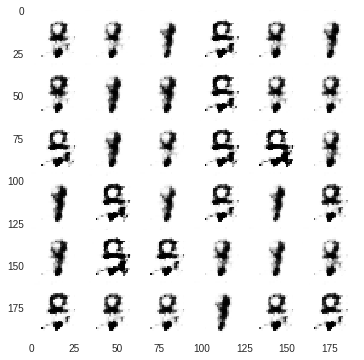

Gen Loss: 1.2176175 Disc Loss: 0.85553515


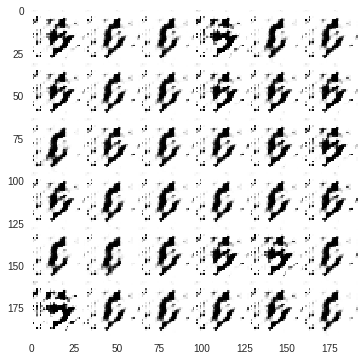

Gen Loss: 1.1506089 Disc Loss: 1.1336857


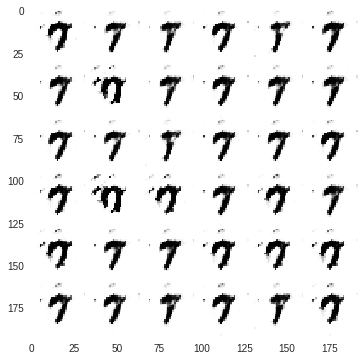

Gen Loss: 1.3465292 Disc Loss: 0.76853657


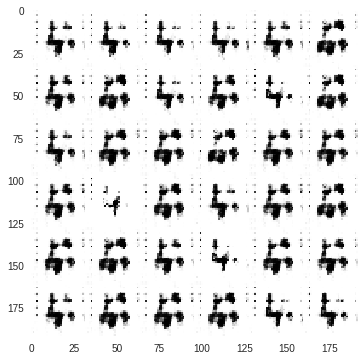

Gen Loss: 1.3733447 Disc Loss: 0.8460177


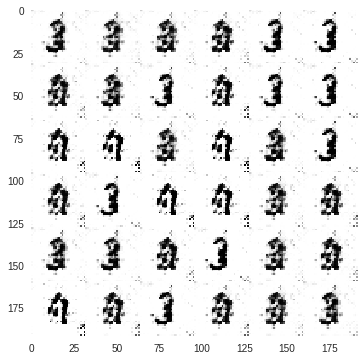

Gen Loss: 0.8749215 Disc Loss: 1.5168471


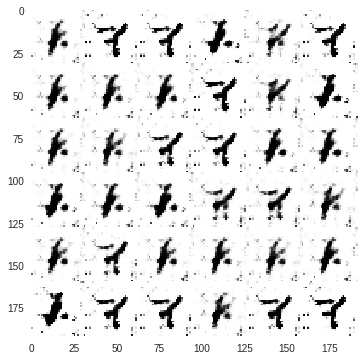

Gen Loss: 1.20366 Disc Loss: 0.97972655


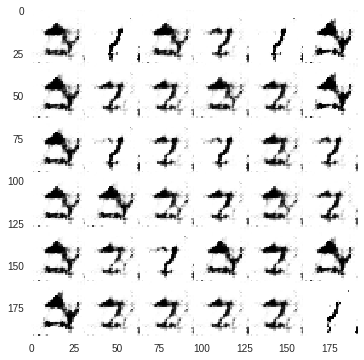

Gen Loss: 1.1676818 Disc Loss: 1.4921718


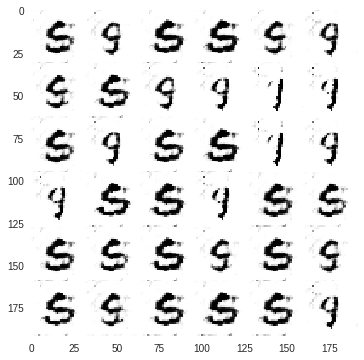

Gen Loss: 1.4777972 Disc Loss: 0.9684516


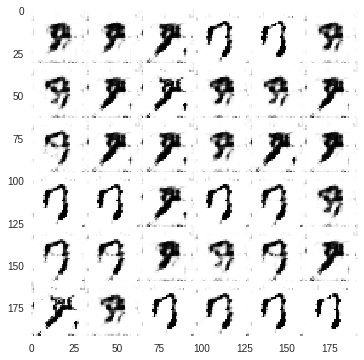

Gen Loss: 1.2462459 Disc Loss: 1.080209


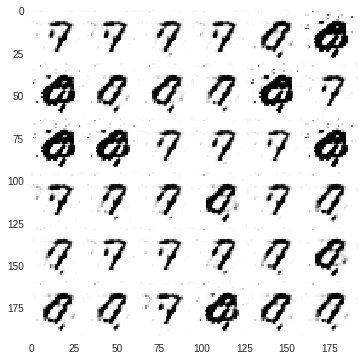

Gen Loss: 1.5900122 Disc Loss: 0.584472


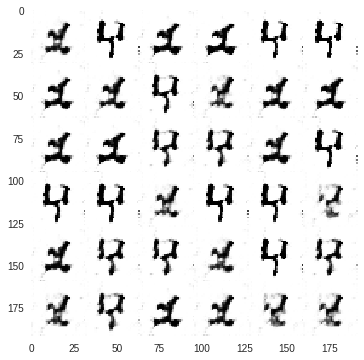

Gen Loss: 1.3451879 Disc Loss: 0.8709878


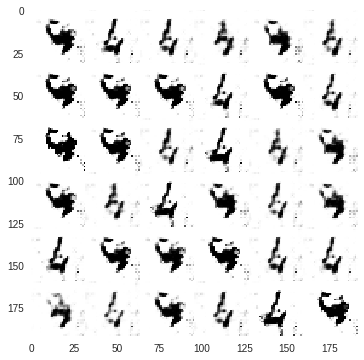

Gen Loss: 1.8146977 Disc Loss: 0.95664465


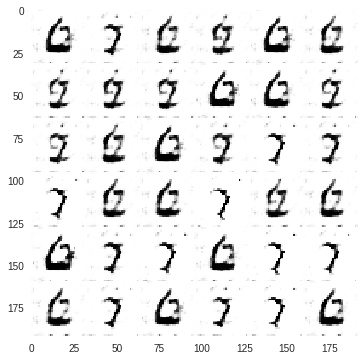

Gen Loss: 1.375556 Disc Loss: 0.8835072


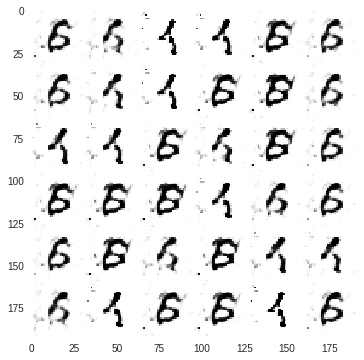

Gen Loss: 1.7025385 Disc Loss: 0.9786493


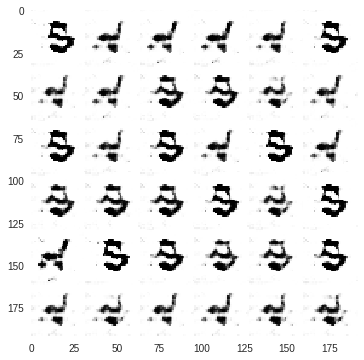

Gen Loss: 1.6984357 Disc Loss: 1.2864746


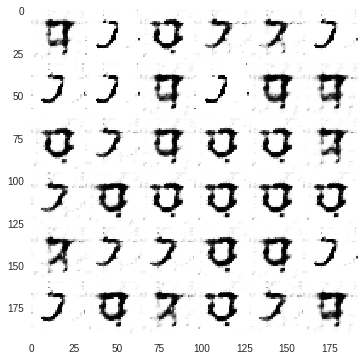

Gen Loss: 1.5997739 Disc Loss: 0.84933025


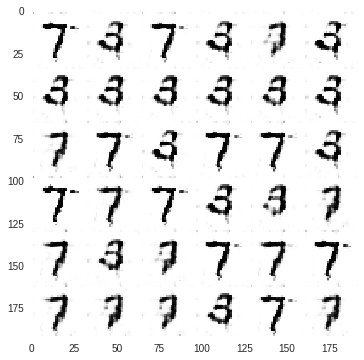

Gen Loss: 1.8549707 Disc Loss: 0.7693105


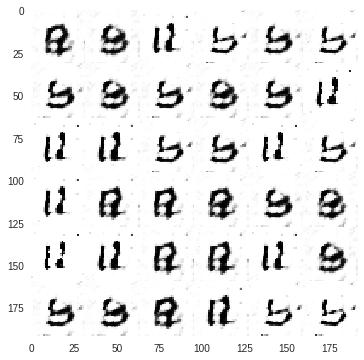

Gen Loss: 1.927447 Disc Loss: 0.55720645


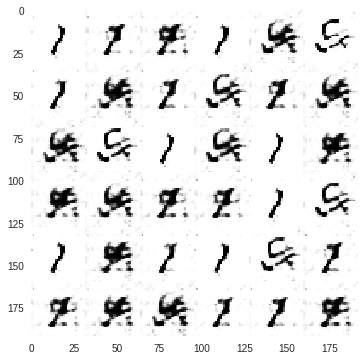

Gen Loss: 1.9451331 Disc Loss: 0.35508376


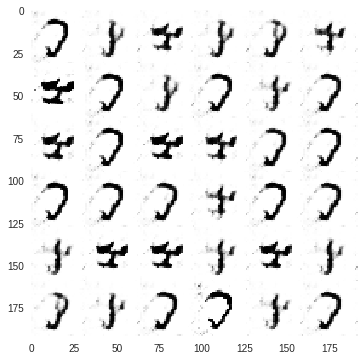

Gen Loss: 2.152966 Disc Loss: 0.40722826


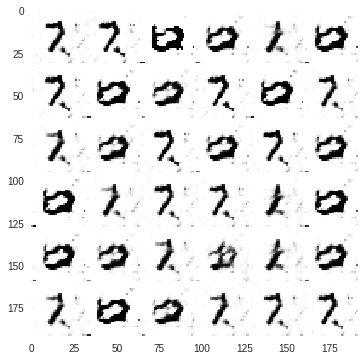

Gen Loss: 1.1824844 Disc Loss: 0.9048218


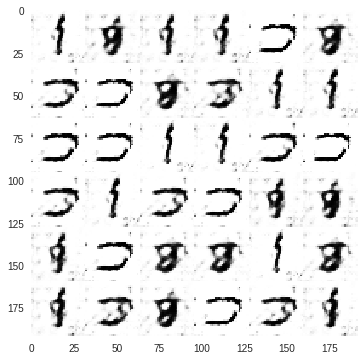

Gen Loss: 1.8752526 Disc Loss: 0.46548852


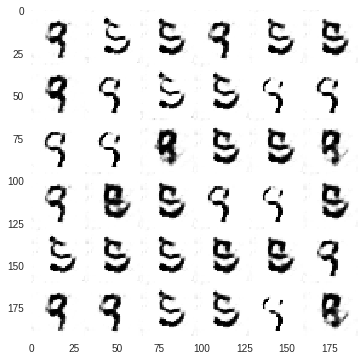

Gen Loss: 1.8798342 Disc Loss: 0.49061432


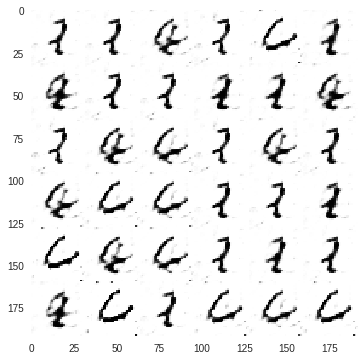

Gen Loss: 1.8028934 Disc Loss: 0.6028967


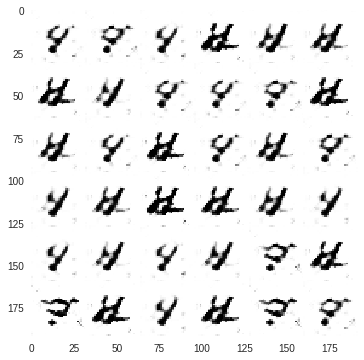

Gen Loss: 2.2057064 Disc Loss: 0.7506039


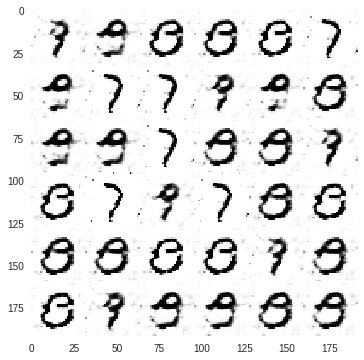

Gen Loss: 1.9325051 Disc Loss: 0.6932968


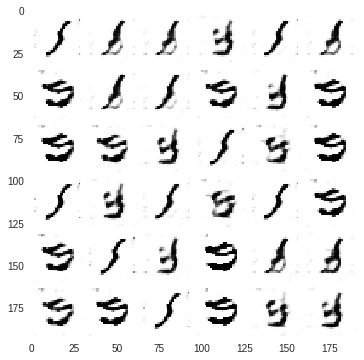

Gen Loss: 1.6464663 Disc Loss: 0.81615096


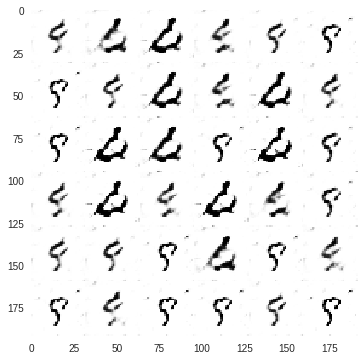

Gen Loss: 1.8776546 Disc Loss: 0.534905


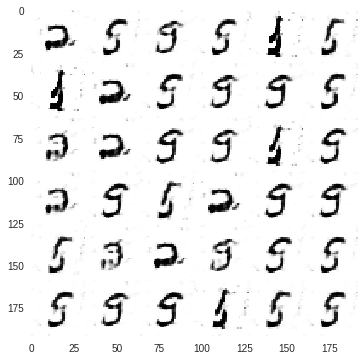

Gen Loss: 1.9513054 Disc Loss: 0.6608889


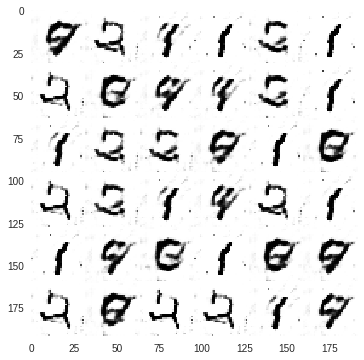

Gen Loss: 1.7535006 Disc Loss: 0.506215


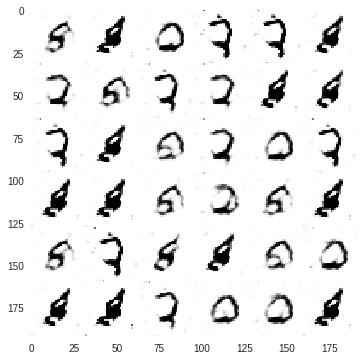

Gen Loss: 1.3305273 Disc Loss: 0.64511895


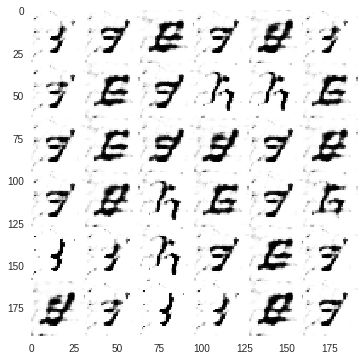

Gen Loss: 2.1169603 Disc Loss: 0.7949531


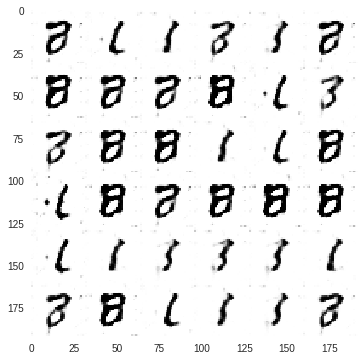

Gen Loss: 1.4856057 Disc Loss: 0.54690707


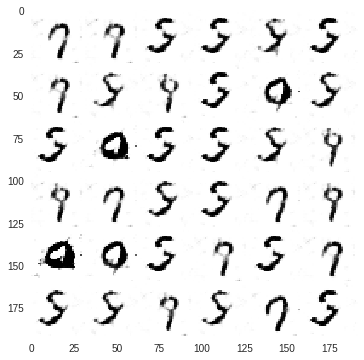

Gen Loss: 1.5202007 Disc Loss: 0.79249096


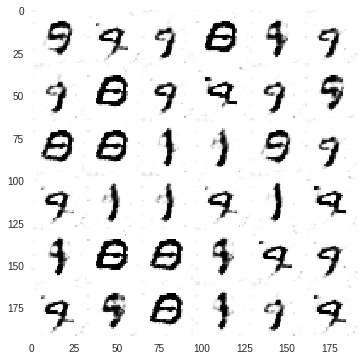

Gen Loss: 1.4623836 Disc Loss: 0.7497672


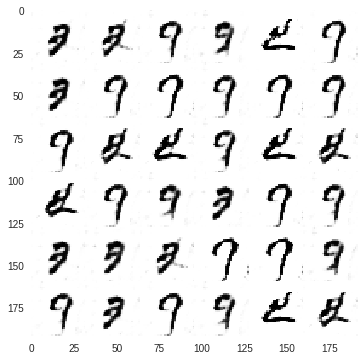

Gen Loss: 0.91039026 Disc Loss: 0.85821664


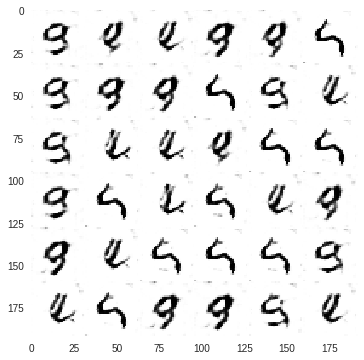

Gen Loss: 1.7627007 Disc Loss: 0.62540334


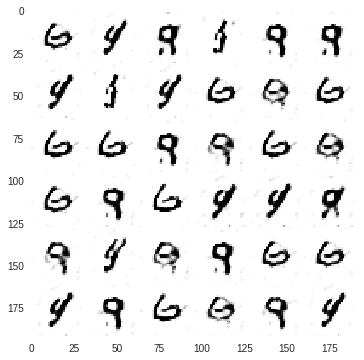

Gen Loss: 1.043709 Disc Loss: 1.1369526


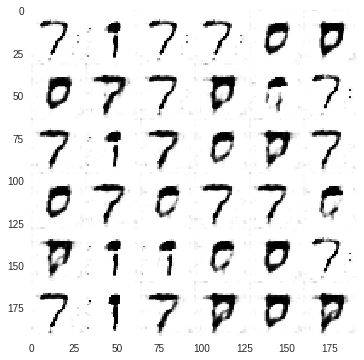

Gen Loss: 1.9664295 Disc Loss: 0.7124859


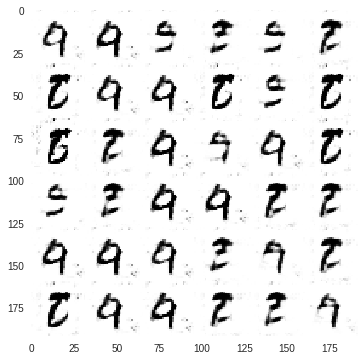

Gen Loss: 3.0507162 Disc Loss: 0.83066666


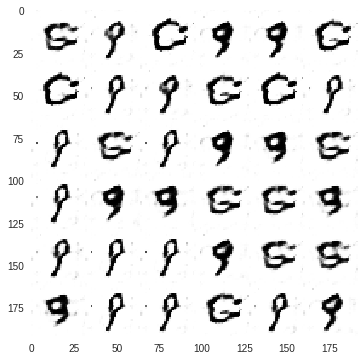

Gen Loss: 1.932175 Disc Loss: 0.47198966


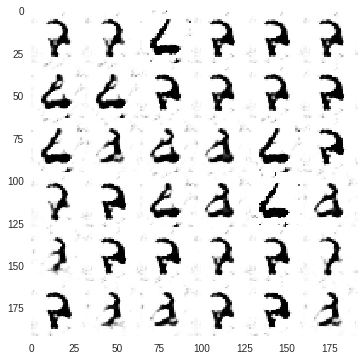

Gen Loss: 1.4123448 Disc Loss: 0.5401279


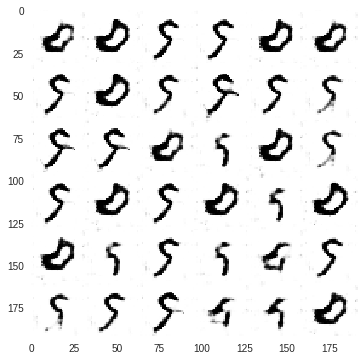

Gen Loss: 1.2427006 Disc Loss: 0.7629614


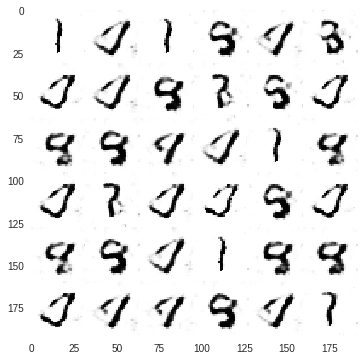

Gen Loss: 2.192721 Disc Loss: 0.4175232


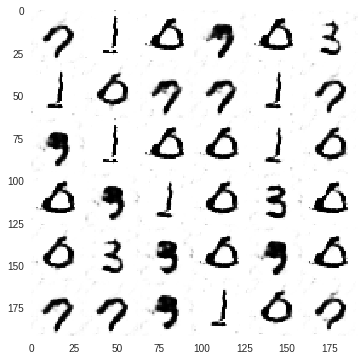

Gen Loss: 1.5022973 Disc Loss: 0.775968


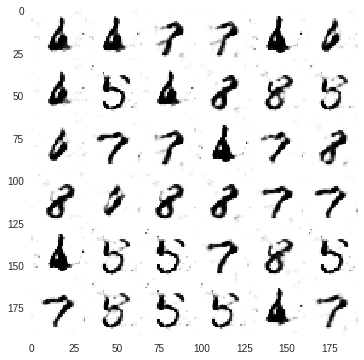

Gen Loss: 1.7413998 Disc Loss: 0.42598242


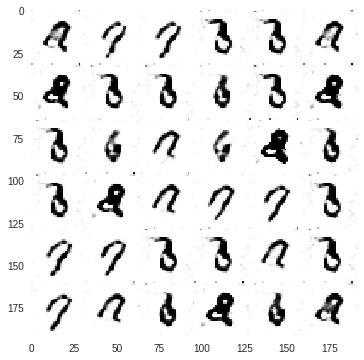

Gen Loss: 2.4110246 Disc Loss: 0.32264856


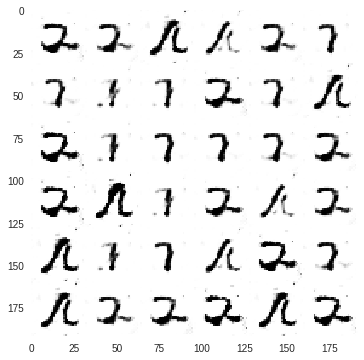

Gen Loss: 1.8386223 Disc Loss: 0.40106013


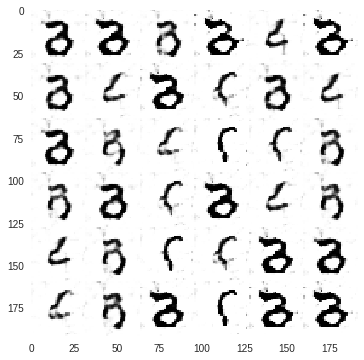

Gen Loss: 2.3542356 Disc Loss: 0.5044985


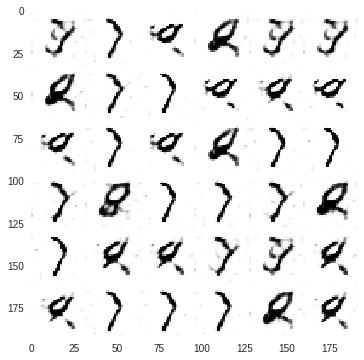

Gen Loss: 2.598746 Disc Loss: 0.27152562


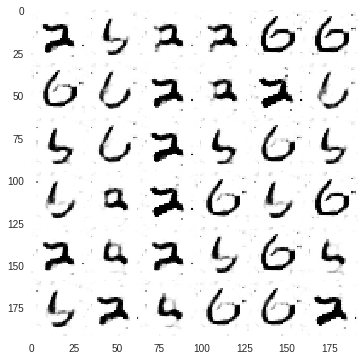

Gen Loss: 1.664087 Disc Loss: 0.5567628


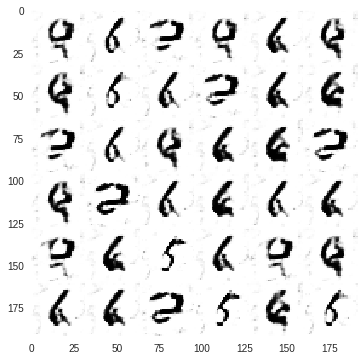

Gen Loss: 1.9911437 Disc Loss: 0.62165433


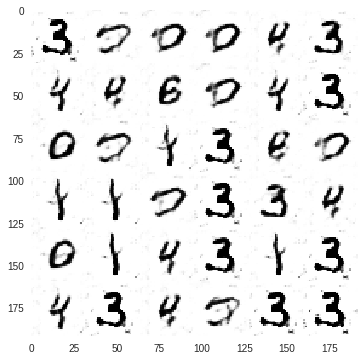

Gen Loss: 2.267051 Disc Loss: 0.5393898


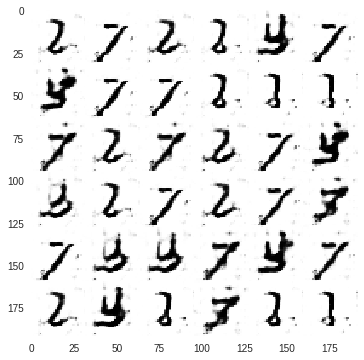

Gen Loss: 1.3837534 Disc Loss: 0.7177285


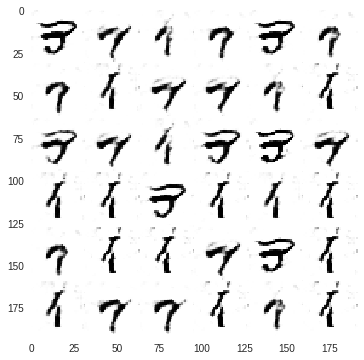

Gen Loss: 1.8915503 Disc Loss: 0.60278845


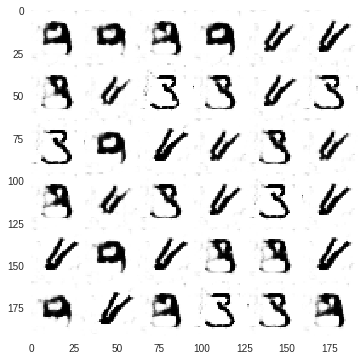

Gen Loss: 1.7130997 Disc Loss: 0.56531316


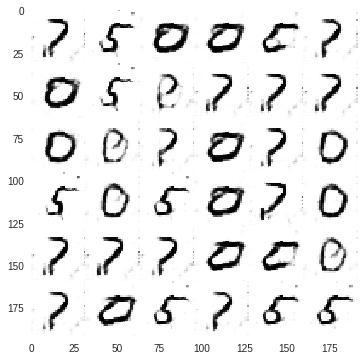

Gen Loss: 1.7721667 Disc Loss: 0.5548332


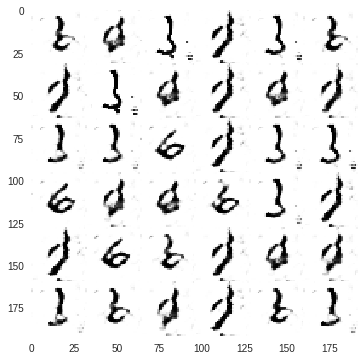

Gen Loss: 2.3297782 Disc Loss: 0.2694522


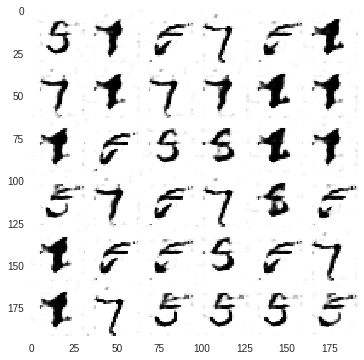

KeyboardInterrupt: ignored

In [8]:
batch_size = 128 #Size of image batch to apply at each iteration.
iterations = 500000 #Total number of iterations to use.
#sample_directory = './figs' #Directory to save sample images from generator in.
#model_directory = './models' #Directory to save trained model to.

init = tf.global_variables_initializer()
#saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    for i in range(iterations):
        zs = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate a random z batch
        xs,_ = mnist.train.next_batch(batch_size) #Draw a sample batch from MNIST dataset.
        xs = (np.reshape(xs,[batch_size,28,28,1]) - 0.5) * 2.0 #Transform it to be between -1 and 1
        xs = np.lib.pad(xs, ((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1)) #Pad the images so the are 32x32
        _,dLoss = sess.run([update_D,d_loss],feed_dict={z_in:zs,real_in:xs}) #Update the discriminator
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs}) #Update the generator, twice for good measure.
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs})
        if i % 100 == 0:
            print("Gen Loss: " + str(gLoss) + " Disc Loss: " + str(dLoss))
            n = 6
            canvas = np.empty((32 * n, 32 * n))
            for i in range(n):
                # Noise input.
                z2 = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate another z batch
                newZ = sess.run(Gz,feed_dict={z_in:z2}) #Use new z to get sample images from generator.
                # Reverse colours for better display
                newZ = -1 * (newZ)
                for j in range(n):
                    # Draw the generated digits
                    canvas[i * 32:(i + 1) * 32, j * 32:(j + 1) * 32] = newZ[j].reshape([32, 32])

            
            plt.figure(figsize=(n, n))
            ax = plt.gca()
            ax.grid(False)
            plt.imshow(canvas, origin="upper", cmap="gray")
            plt.show()
            
            
            #if not os.path.exists(sample_directory):
            #    os.makedirs(sample_directory)
            #Save sample generator images for viewing training progress.
            #save_images(np.reshape(newZ[0:36],[36,32,32]),[6,6],sample_directory+'/fig'+str(i)+'.png')
        #if i % 1000 == 0 and i != 0:
            #if not os.path.exists(model_directory):
            #    os.makedirs(model_directory)
            #saver.save(sess,model_directory+'/model-'+str(i)+'.cptk')
            #print("Saved Model")

## Using a trained network
Once we have a trained model saved, we may want to use it to generate new images, and explore the representation it has learned.

In [8]:
"""
sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to load trained model from.
batch_size_sample = 36

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    #Reload the model.
    print('Loading Model...')
    ckpt = tf.train.get_checkpoint_state(path)
    saver.restore(sess,ckpt.model_checkpoint_path)
    
    zs = np.random.uniform(-1.0,1.0,size=[batch_size_sample,z_size]).astype(np.float32) #Generate a random z batch
    newZ = sess.run(Gz,feed_dict={z_in:z2}) #Use new z to get sample images from generator.
    if not os.path.exists(sample_directory):
        os.makedirs(sample_directory)
    save_images(np.reshape(newZ[0:batch_size_sample],[36,32,32]),[6,6],sample_directory+'/fig'+str(i)+'.png')
"""

Loading Model...


NameError: ignored